<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE60499](https://ndcbe.github.io/CBE60499);
content is available [on Github](git@github.com:ndcbe/CBE60499.git).*


<!--NAVIGATION-->
< [4.7 Simple Netwon Method for Equality Constrained NLPs](https://ndcbe.github.io/CBE60499/04.07-Interior-Point1.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [4.9 Algorithms Homework 4: Interior Point Methods](https://ndcbe.github.io/CBE60499/04.09-Algorithms4.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/04.08-Interior-Point2.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/04.08-Interior-Point2.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 4.8 Inertia-Corrected Netwon Method for Equality Constrained NLPs


Background:

![Eqn5-12](figures/eqn5-12.png)

The Algorithm:

![Alg5-2a](figures/alg5-2a.png)

![Alg5-2b](figures/alg5-2b.png)

## 4.8.1 Helper Functions

In [1]:
# Load required Python libraries.
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

## Check is element of array is NaN
def check_nan(A):
    return np.sum(np.isnan(A))

## Calculate gradient with central finite difference
## Calculate gradient with central finite difference
def my_grad_approx(x,f,eps1,verbose=False):
    '''
    Calculate gradient of function f using central difference formula
    
    Inputs:
        x - point for which to evaluate gradient
        f - function to consider
        eps1 - perturbation size
        
    Outputs:
        grad - gradient (vector)
    '''
    
    n = len(x)
    grad = np.zeros(n)
    
    if(verbose):
        print("***** my_grad_approx at x = ",x,"*****")
    
    for i in range(0,n):
        
        # Create vector of zeros except eps in position i
        e = np.zeros(n)
        e[i] = eps1
        
        # Finite difference formula
        my_f_plus = f(x + e)
        my_f_minus = f(x - e)
        
        # Diagnostics
        if(verbose):
            print("e[",i,"] = ",e)
            print("f(x + e[",i,"]) = ",my_f_plus)
            print("f(x - e[",i,"]) = ",my_f_minus)
        
        
        grad[i] = (my_f_plus - my_f_minus)/(2*eps1)
    
    if(verbose):
        print("***** Done. ***** \n")
    
    return grad

def my_jac_approx(x,h,eps1,verbose=False):
    '''
    Calculate Jacobian of function h(x) using central difference formula
    
    Inputs:
        x - point for which to evaluate gradient
        h - vector-valued function to consider. h(x): R^n --> R^m
        eps1 - perturbation size
        
    Outputs:
        A - Jacobian (n x m matrix)
    '''
    
    # Check h(x) at x
    h_x0 = h(x)
    
    # Extract dimensions
    n = len(x)
    m = len(h_x0)
    
    # Initialize Jacobian matrix
    A = np.zeros((n,m))
    
    # Calculate Jacobian by row
    for i in range(0,n):
        
        # Create vector of zeros except eps in position i
        e = np.zeros(n)
        e[i] = eps1
        
        # Finite difference formula
        my_h_plus = h(x + e)
        my_h_minus = h(x - e)
        
        # Diagnostics
        if(verbose):
            print("e[",i,"] = ",e)
            print("h(x + e[",i,"]) = ",my_h_plus)
            print("h(x - e[",i,"]) = ",my_h_minus)
        
        
        A[i,:] = (my_h_plus - my_h_minus)/(2*eps1)
    
    if(verbose):
        print("***** Done. ***** \n")
    
    return A
    
## Calculate gradient using central finite difference and my_hes_approx
def my_hes_approx(x,grad,eps2):
    '''
    Calculate gradient of function my_f using central difference formula and my_grad
    
    Inputs:
        x - point for which to evaluate gradient
        grad - function to calculate the gradient
        eps2 - perturbation size (for Hessian NOT gradient approximation)
        
    Outputs:
        H - Hessian (matrix)
    '''
    
    n = len(x)
    H = np.zeros([n,n])
    
    for i in range(0,n):
        # Create vector of zeros except eps in position i
        e = np.zeros(n)
        e[i] = eps2
        
        # Evaluate gradient twice
        grad_plus = grad(x + e)
        grad_minus = grad(x - e)
        
        # Notice we are building the Hessian by column (or row)
        H[:,i] = (grad_plus - grad_minus)/(2*eps2)

    return H

## Linear algebra calculation
def xxT(u):
    '''
    Calculates u*u.T to circumvent limitation with SciPy
    
    Arguments:
    u - numpy 1D array
    
    Returns:
    u*u.T
    
    Assume u is a nx1 vector.
    Recall: NumPy does not distinguish between row or column vectors
    
    u.dot(u) returns a scalar. This functon returns an nxn matrix.
    '''
    
    n = len(u)
    A = np.zeros([n,n])
    for i in range(0,n):
        for j in range(0,n):
            A[i,j] = u[i]*u[j]
    
    return A

## Analyze Hessian
def analyze_hes(B):
    print(B,"\n")
    
    l = linalg.eigvals(B)
    print("Eigenvalues: ",l,"\n")

## 4.8.2 Algorithm 5.2

In [2]:
def assemble_check_KKT(W,A,deltaA,deltaW,verbose):
    
    n = np.size(W,0)
    
    if(np.size(W,1) != n):
        print("WARNING: W is not square. Somthing is broken.")
        
    rA = np.size(A,0)
    m = np.size(A,1)
    
    if(rA != n):
        print("WARNING: A does not have the corrent number of rows.")
    
    # Assemble KKT matrix
    KKT_top = np.concatenate((W + deltaW*np.eye(n),A),axis=1)
    KKT_bot = np.concatenate((A.T,-deltaA*np.eye(m)),axis=1)
    KKT = np.concatenate((KKT_top,KKT_bot),axis=0)
        
    # Check inertia of KKT matrix.
    # Out of simplicity, we will just calculate the eigenvalues.
    # Biegler, 2010 explains a more sophisticates (and computationally efficient)
    # strategy
    l, eigvec = linalg.eig(KKT)

    zero_tol = 1E-12

    # Count number of positive eigenvalues
    pos_ev = sum(l >= zero_tol)

    # Count number of eigenvalues close to zero
    zero_ev = sum(np.abs(l) < zero_tol)

    # Count number of negative eigenvalues
    neg_ev = sum(l <= -zero_tol)

    inertia_correct = (n == pos_ev and m == neg_ev)
    
    if(verbose):
        print("deltaA = ",deltaA,"  deltaW = ",deltaW,"intertia =(",pos_ev,",",neg_ev,",",zero_ev,")\n")
    
    return KKT,inertia_correct,pos_ev,neg_ev,zero_ev
    
def alg52(x0,calc_f,calc_h,eps1=1E-6,eps2=1E-6,max_iter=10,verbose=False):
    '''
    Basic Full Space Newton Method for Equality Constrained NLP
    
    Input:
        x0 - starting point (vector)
        calc_f - function to calculate objective (returns scalar)
        calc_h - function to calculate constraints (returns vector)
        eps1 - tolerance for primal and dual steps
        eps2 - tolerance for gradient of L1
        
    Outputs:
        x - history of steps (primal variables)
        v - history of steps (dual variables)
        f - history of objective evaluations
        h - history of constraint evaluations
        df - history of objective gradients
        dL - history of Lagrange function gradients
        A - history of constraint Jacobians
        W - history of Lagrange Hessians
    
    Notes:
        1. For simplicity, central finite difference is used 
           for all gradient calculations.
    '''

    ### Specifics for Algorithm 5.2
    # Tuning parameters
    delta_bar_W_min = 1E-20
    delta_bar_W_0 = 1E-4
    delta_bar_W_max = 1E40
    delta_bar_A = 1E-8
    kappa_u = 8
    kappa_l = 1/3
    
    # Declare iteration histories as empty lists
    x = []
    v = []
    f = []
    L = []
    h = []
    df = []
    dL = []
    A = []
    W = []

    # Set for first iteration
    delta_A = 0.0
    delta_W = 0.0
    delta_W_last = 0.0
    
    # Flag for iterations
    flag = True
    
    # Iteration counter
    k = 0
    
    # Copy initial point to primal variable history
    n = len(x0)
    x.append(x0)
    
    # Evaluate objective and constraints at initial point
    f.append(calc_f(x0))
    h.append(calc_h(x0))
    
    # Determine number of equality constraints
    m = len(h[0])
    
    # Initial dual variables with vector of ones
    v.append(np.ones(m))
    
    # Print header for iteration information
    print("Iter. \tf(x) \t\t||h(x)|| \t||grad_L(x)|| \t||dx|| \t\t||dv|| \t\tdelta_A \tdelta_W")
    
    while(flag and k < max_iter):
        
        # STEP 1. Construct KKT matrix
        
        if(k > 0):
            # Evaluate objective function
            f.append(calc_f(x[k]))
            
            # Evaluate constraint function
            h.append(calc_h(x[k]))
        
        # Evaluate objective gradient
        df.append(my_grad_approx(x[k],calc_f,1E-6))
        
        # Evaluate constraint Jacobian
        A.append(my_jac_approx(x[k],calc_h,1E-6))
        
        # Evaluate gradient of Lagrange function
        L_func = lambda x_ : calc_f(x_) + (calc_h(x_)).dot(v[k])
        L_grad = lambda x_ : my_grad_approx(x_,L_func,1E-6)
        dL.append(L_grad(x[k]))
        norm_dL = linalg.norm(dL[k])
        
        # Evaluate Hessian of Lagrange function
        W.append(my_hes_approx(x[k],L_grad,1E-6))
        
        if(verbose):
            print("*** k =",k," ***")
            print("x_k =",x[k])
            print("v_k =",v[k])
            print("f_k =",f[k])
            print("df_k =",df[k])
            print("h_k =",h[k])
            print("A_k =\n",A[k])
            print("W_k =\n",W[k])
            print("\n")
        
        ######
        # Algorithm 5.2: Add intertia correction to Algorithm 5.1
                
        ### ALG. 5.2, STEP 1
        delta_A = 0
        delta_W = 0
        
        KKT,inertia_correct,pos_ev,neg_ev,zero_ev = assemble_check_KKT(W[k],A[k],delta_A,delta_W,verbose)
        
        if not inertia_correct:
            ### ALG. 5.2, STEP 2
            # Assume zero eigenvalue is from rank-deficient Jacobian.
            # Set delta_A to non-zero value
            if zero_ev != 0:
                delta_A = delta_bar_A
            
            ### ALG. 5.2, STEP 3
            if delta_W_last == 0:
                delta_W = delta_bar_W_0
            else:
                delta_W = max(delta_bar_W_min,kappa_l*delta_W_last)

        while (not inertia_correct) and flag:
            ### ALG. 5.2, STEP 4
            KKT,inertia_correct,pos_ev,neg_ev,zero_ev = assemble_check_KKT(W[k],A[k],delta_A,delta_W,verbose)
            
            ### ALG. 5.2, STEP 5
            if not inertia_correct:
                delta_W = kappa_u*delta_W
                
            ### ALG. 5.2, STEP 6
            if delta_W > delta_bar_W_max:
                flag = False
                print("Abort step computation. KKT matrix is severely ill-conditioned.")
            
        delta_W_last = delta_W
                
        ## STEP 2. Solve linear system.
        
        if flag:
            b = -np.concatenate((dL[k],h[k]),axis=0)
            z = linalg.solve(KKT,b)
        else:
            z = []
            
        ## STEP 3. Take step
        if flag:
            dx = z[0:n]
            dv = z[n:(n+m+1)]
            
            x.append(x[k] + dx)
            v.append(v[k] + dv)
            
            norm_dx = linalg.norm(dx)
            norm_dv = linalg.norm(dv)
        
        ## Print iteration information
        print(k,'  \t{0: 1.4e} \t{1:1.4e} \t{2:1.4e}'.format(f[k],linalg.norm(h[k]),norm_dL),end='')
        
        if flag:
            print(' \t{0: 1.4e} \t{1: 1.4e}'.format(norm_dx,norm_dv),end='')
        else:
            print(' \t -------  \t -------',end='')
        
        print(' \t{0: 1.4e} \t{1: 1.4e}'.format(delta_A,delta_W),end='\n')
        
        # Increment counter
        k = k + 1
        
        ## Check convergence criteria
        if(flag):
            flag = norm_dx > eps1 and norm_dv > eps1 and norm_dL > eps2
    
    if(not flag and k > max_iter):
        print("Reached maximum number of iterations.")
    
    return x,v,f,h,df,dL,A,W

## 4.8.3 Example Problem 2

(Where is Example Problem 1? We are using the same number scheme as the previous notebook.)

Consider:
$$\begin{align}\min_x \quad & x_1^2 + 2 x_2^2 \\
\mathrm{s.t.} \quad & x_1 + x_2 = 1 \\
 & x_1 + x_2 = 1 \end{align}$$

### Test Algorithm 5.2 with redundant constraints.

In [3]:
## Define functions
def my_f2(x):
    return x[0]**2 + 2*x[1]**2

def my_h2(x):
    h = np.zeros(2)
    h[0] = x[0] + x[1] - 1
    h[1] = h[0]
    return h

## Declare initial point
x0 = np.array((1,1))

## Run Algorithm 5.2 on test problem
results = alg52(x0,my_f2,my_h2,verbose=False)

## Display results
xstar = results[0][-1]
print("\nx* =",xstar)

## Display results
vstar = results[1][-1]
print("\nv* =",vstar)

Iter. 	f(x) 		||h(x)|| 	||grad_L(x)|| 	||dx|| 		||dv|| 		delta_A 	delta_W
0   	 3.0000e+00 	1.4142e+00 	7.2111e+00 	 7.4537e-01 	 2.3571e+00 	 1.0000e-08 	 1.0000e-04
1   	 6.6667e-01 	2.3373e-08 	2.9368e-04 	 5.4908e-05 	 9.4088e-05 	 1.0000e-08 	 3.3333e-05
2   	 6.6667e-01 	9.4991e-13 	3.7259e-09 	 1.1908e-09 	 6.4780e-11 	 1.0000e-08 	 1.1111e-05

x* = [0.66666667 0.33333333]

v* = [-0.66666666 -0.66666667]


### 4.8.3.1 Test Algorithm 5.2 without redundant constraints.

In [4]:
## Define functions
def my_h2b(x):
    return (x[0] + x[1] - 1)*np.ones(1)

## Run Algorithm 5.2 on test problem
results = alg52(x0,my_f2,my_h2b,verbose=False)

## Display results
xstar = results[0][-1]
print("\nx* =",xstar)

## Display results
vstar = results[1][-1]
print("\nv* =",vstar)

Iter. 	f(x) 		||h(x)|| 	||grad_L(x)|| 	||dx|| 		||dv|| 		delta_A 	delta_W
0   	 3.0000e+00 	1.0000e+00 	5.8310e+00 	 7.4537e-01 	 2.3335e+00 	 0.0000e+00 	 0.0000e+00
1   	 6.6667e-01 	1.3978e-10 	2.9473e-04 	 4.5326e-05 	 1.5285e-04 	 0.0000e+00 	 0.0000e+00
2   	 6.6667e-01 	0.0000e+00 	4.5431e-09 	 1.4393e-09 	 2.0170e-09 	 0.0000e+00 	 0.0000e+00

x* = [0.66666667 0.33333333]

v* = [-1.33333333]


### 4.8.3.2 Discussion

* Compare the multipliers with and without the redundant constraint.

## 4.8.4 Example Problem 3

Let us try a model where $\nabla h(x^k)^T$ is full rank but there are multiple local optima.

Consider:
$$\begin{align}\min_x \quad & x_1^3 - x_2 -x_1 x_2 - x_2^2 \\
\mathrm{s.t.} \quad & x_1^2 + x_2^2 = 1
\end{align}$$

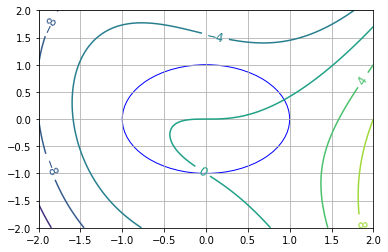

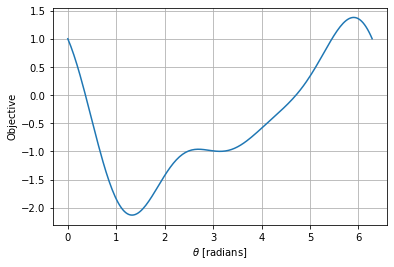

In [5]:
## Copied from notebook with Algorithm 5.1
def my_f3(x):
    return x[0]**3 - x[1] - x[0]*x[1] - x[1]**2

def my_h3(x):
    return (x[0]**2 + x[1]**2 - 1)*np.ones(1)

def visualize(xk=[]):
    n1 = 101
    n2 = 101
    x1eval = np.linspace(-2,2,n1)
    x2eval = np.linspace(-2,2,n2)
    
    X, Y = np.meshgrid(x1eval, x2eval)
    
    Z = np.zeros([n2,n1])
    
    for i in range(0,n1):
        for j in range(0,n2):
            Z[j,i] = my_f3((X[j,i], Y[j,i]))
            
    fig, ax = plt.subplots(1,1)
    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=1, fontsize=12)

    # Add grid
    plt.grid()
    
    # Add unit circle
    circ = plt.Circle((0, 0), radius=1, edgecolor='b', facecolor='None')
    ax.add_patch(circ)
    
    # Plot iteration history
    if len(xk) > 0:
        for i in range(0,len(xk)):
            if i == len(xk) - 1:
                c = "red"
            else:
                c = "black"
            plt.scatter((xk[i][0]),(xk[i][1]),marker='o',color=c)
    
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    
visualize()

nt = 200
theta = np.linspace(0,2*np.pi,nt)
obj = np.zeros(nt)


for i in range(0,nt):
    x_ = np.cos(theta[i])
    y_ = np.sin(theta[i])
    
    obj[i] = my_f3((x_,y_))


plt.figure()
plt.plot(theta,obj)
plt.xlabel('$\\theta$ [radians]')
plt.ylabel('Objective')
plt.grid()

### 4.8.4.1 Starting Point Near Global Min ($\theta_0 = 1.0$)

Iter. 	f(x) 		||h(x)|| 	||grad_L(x)|| 	||dx|| 		||dv|| 		delta_A 	delta_W
0   	-6.9105e-01 	0.0000e+00 	3.7501e+00 	 1.1171e+00 	 1.1455e+00 	 0.0000e+00 	 0.0000e+00
1   	-4.0104e+00 	1.2480e+00 	2.1729e+00 	 4.2318e-01 	 3.9672e-01 	 0.0000e+00 	 0.0000e+00
2   	-2.4216e+00 	1.7908e-01 	3.3575e-01 	 8.3649e-02 	 1.0205e-01 	 0.0000e+00 	 0.0000e+00
3   	-2.1438e+00 	6.9971e-03 	1.7074e-02 	 3.5294e-03 	 6.5710e-03 	 0.0000e+00 	 0.0000e+00
4   	-2.1324e+00 	1.2457e-05 	4.6327e-05 	 6.3597e-06 	 1.9707e-05 	 0.0000e+00 	 0.0000e+00
5   	-2.1323e+00 	4.0446e-11 	1.4043e-09 	 2.8044e-10 	 3.3891e-11 	 0.0000e+00 	 0.0000e+00

x* = [0.24215301 0.97023807]

v* = [1.64012795]

theta* = 1.326212035697004 = 1.3262120356970035


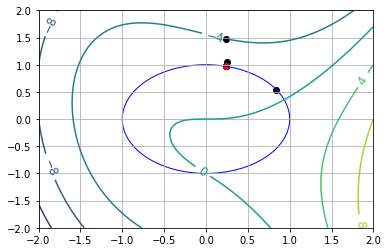

In [6]:
theta0 = 1.0
x0 = np.array((np.sin(theta0),np.cos(theta0)))

## Run Algorithm 5.1 on test problem
results = alg52(x0,my_f3,my_h3)

## Display results
xstar = results[0][-1]
print("\nx* =",xstar)

## Display results
vstar = results[1][-1]
print("\nv* =",vstar)

## Convert into theta
print("\ntheta* =",np.arccos(xstar[0]),"=",np.arcsin(xstar[1]))

## Visualize
visualize(results[0])

### 4.8.4.2 Starting Point Near Local Min ($\theta_0 = \pi$)

Iter. 	f(x) 		||h(x)|| 	||grad_L(x)|| 	||dx|| 		||dv|| 		delta_A 	delta_W
0   	 2.2204e-16 	0.0000e+00 	1.4142e+00 	 5.0002e-01 	 2.4998e-01 	 0.0000e+00 	 0.0000e+00
1   	-6.2504e-01 	2.5002e-01 	1.0000e+00 	 3.0322e-01 	 4.1490e-01 	 0.0000e+00 	 3.2768e+00
2   	-7.1455e-01 	9.1941e-02 	8.2867e-01 	 6.9738e+00 	 3.9656e+00 	 0.0000e+00 	 0.0000e+00
3   	-1.9540e+02 	4.8634e+01 	5.3609e+01 	 7.3453e+00 	 8.9486e+00 	 0.0000e+00 	 3.2768e+00
4   	-6.6453e+01 	5.3954e+01 	7.3649e+01 	 3.6845e+00 	 4.7204e+00 	 0.0000e+00 	 8.7381e+00
5   	-2.0079e+01 	1.3575e+01 	2.6604e+00 	 1.7791e+00 	 2.6030e-01 	 0.0000e+00 	 0.0000e+00
6   	-6.7442e+00 	3.1651e+00 	9.2895e-01 	 7.7547e-01 	 2.3764e-01 	 0.0000e+00 	 0.0000e+00
7   	-3.0811e+00 	6.0135e-01 	3.5585e-01 	 2.3833e-01 	 1.8564e-01 	 0.0000e+00 	 0.0000e+00
8   	-2.2251e+00 	5.6802e-02 	8.3998e-02 	 2.7726e-02 	 5.2689e-02 	 0.0000e+00 	 0.0000e+00
9   	-2.1336e+00 	7.6871e-04 	2.8474e-03 	 3.8422e-04 	 1.6169e-03 	 0.0000e+00 	 0.0000e

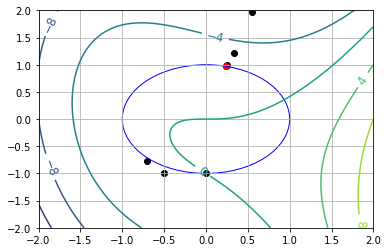

In [7]:
theta0 = np.pi
x0 = np.array((np.sin(theta0),np.cos(theta0)))

## Run Algorithm 5.1 on test problem
results = alg52(x0,my_f3,my_h3)

## Display results
xstar = results[0][-1]
print("\nx* =",xstar)

## Display results
vstar = results[1][-1]
print("\nv* =",vstar)

## Convert into theta
print("\ntheta* =",np.arccos(xstar[0]),"(using arccos)")
print("\ntheta* =",np.arcsin(xstar[1]),"(using arcsin)")

## Visualize
visualize(results[0])

### 4.8.4.3 Starting Point Near Global Max ($\theta_0 = 5.5$)

Iter. 	f(x) 		||h(x)|| 	||grad_L(x)|| 	||dx|| 		||dv|| 		delta_A 	delta_W
0   	-1.0621e+00 	0.0000e+00 	6.9215e-01 	 5.6411e-01 	 4.3032e-01 	 0.0000e+00 	 3.2768e+00
1   	-2.0216e+00 	3.1822e-01 	2.0226e+00 	 2.3706e-01 	 1.1375e+00 	 0.0000e+00 	 8.7381e+00
2   	-1.9886e+00 	5.6197e-02 	1.3940e+00 	 4.4244e-01 	 4.9825e-02 	 0.0000e+00 	 0.0000e+00
3   	-2.4244e+00 	1.9575e-01 	5.4298e-01 	 1.2207e-01 	 1.5280e-02 	 0.0000e+00 	 0.0000e+00
4   	-2.1566e+00 	1.4900e-02 	3.8186e-02 	 1.0366e-02 	 1.9242e-03 	 0.0000e+00 	 0.0000e+00
5   	-2.1325e+00 	1.0745e-04 	2.7129e-04 	 7.4929e-05 	 1.7543e-05 	 0.0000e+00 	 0.0000e+00
6   	-2.1323e+00 	5.6144e-09 	3.7221e-09 	 2.8396e-09 	 2.9955e-09 	 0.0000e+00 	 0.0000e+00

x* = [0.24215301 0.97023807]

v* = [1.64012795]

theta* = 1.3262120357119471 (using arccos)

theta* = 1.3262120357119473 (using arcsin)


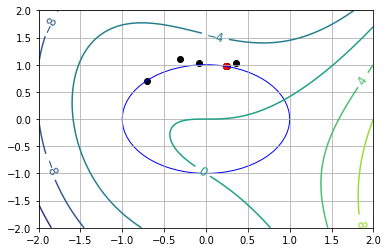

In [8]:
theta0 = 5.5
x0 = np.array((np.sin(theta0),np.cos(theta0)))

## Run Algorithm 5.1 on test problem
results = alg52(x0,my_f3,my_h3)

## Display results
xstar = results[0][-1]
print("\nx* =",xstar)

## Display results
vstar = results[1][-1]
print("\nv* =",vstar)

## Convert into theta
print("\ntheta* =",np.arccos(xstar[0]),"(using arccos)")
print("\ntheta* =",np.arcsin(xstar[1]),"(using arcsin)")

## Visualize
visualize(results[0])

<!--NAVIGATION-->
< [4.7 Simple Netwon Method for Equality Constrained NLPs](https://ndcbe.github.io/CBE60499/04.07-Interior-Point1.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [4.9 Algorithms Homework 4: Interior Point Methods](https://ndcbe.github.io/CBE60499/04.09-Algorithms4.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/04.08-Interior-Point2.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/04.08-Interior-Point2.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>